In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import torch
from torch.utils.data import DataLoader
from model import EmoCatcher
from dataset import MyOwnDBMelS, emotion_dict
from dataloader import get_meta, split_meta, mels2batchMyOwn
from utils.evaluation import create_confusion_matrix, average_recall
from utils.evaluation import plot_cm, plot_metric_curve, plot_predicted_example
from tqdm import tqdm 

In [2]:
mel_kwargs = {"n_mels":80, "fmax": 8000, "win_length": 1024, "hop_length" : 256, "n_fft": 1024}
test_dset = MyOwnDBMelS("filelists/emotion_test_filelist.txt", mel_specs_kwargs=mel_kwargs)
test_dloader = DataLoader(test_dset, batch_size=64, collate_fn=mels2batchMyOwn, shuffle=False)

In [3]:
## best model path
import glob
model_path = glob.glob(f"./output/model/best_model*.pth")[0]

## load trained model
model = EmoCatcher(input_dim=80, hidden_dim=512, kernel_size=3, num_classes=5)
model.load_state_dict(torch.load(model_path))
model.eval()

EmoCatcher(
  (conv_block1): Conv1dLNBlock(
    (conv_block): Sequential(
      (0): Conv1d(80, 256, kernel_size=(3,), stride=(1,), padding=same)
      (1): ConvLN(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): GELU(approximate='none')
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (conv_block2): Conv1dLNBlock(
    (conv_block): Sequential(
      (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
      (1): ConvLN(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (2): GELU(approximate='none')
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (conv_block3): Conv1dLNBlock(
    (conv_block): Sequential(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=same)
      (1): ConvLN(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (2): GELU(approximate='none')
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (maxpool1): 

In [4]:
holdout_outdir = 'output/'

FileNotFoundError: [Errno 2] No such file or directory: '/run/media/fourier/Data2/Pras/Thesis/Emotion_Recognition/T_EmoCatherMyOwn/output/img/metric_curves.jpg'

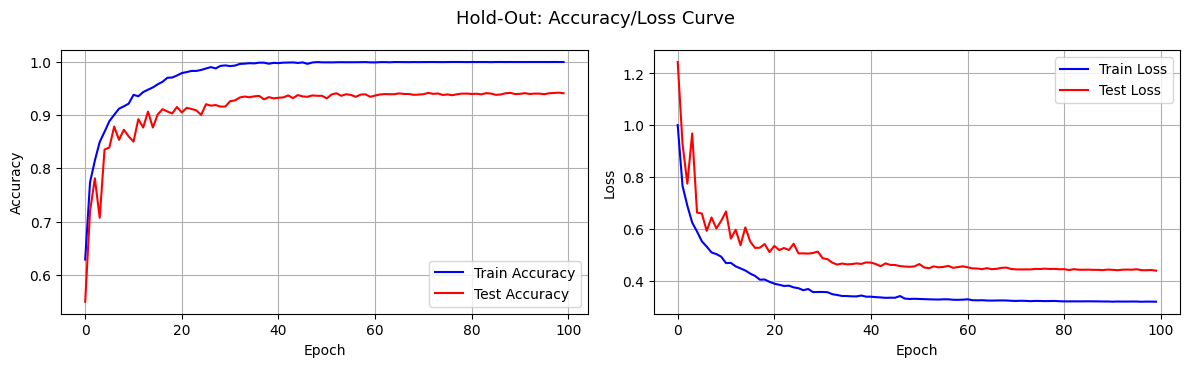

In [16]:
# Load metric log dictionary
with open(f'./{holdout_outdir}/logs/metric_log_dict.pkl', 'rb') as f:
    metric_log_dict = pickle.load(f)
fig = plot_metric_curve(metric_log_dict['train'].values(), metric_log_dict['test'].values(), plot_kwargs={'figsize': (12,3.7), 'dpi': 100})
fig.suptitle('Hold-Out: Accuracy/Loss Curve', size = 13)
fig.tight_layout()
fig.savefig(f'{holdout_outdir}img/metric_curves.jpg')
test_best_acc_ind = np.argmax(metric_log_dict['test']['acc'])
print('Best Test Accuracy / Loss: {:.2f}% / {:.5f}'.format(metric_log_dict['test']['acc'][test_best_acc_ind]*100, metric_log_dict['test']['loss'][test_best_acc_ind])) 

In [13]:
total_ypred = np.array([])
total_zhid = np.array([])

for x_test, y_test, L in test_dloader:
    y_pred_test, z_hidden = model(x_test, L)
    y_pred_test = y_pred_test.argmax(dim = 1)

    total_ypred = np.concatenate([total_ypred, y_pred_test.cpu().detach().numpy()], axis=0)
    total_zhid = np.append(total_zhid, z_hidden.cpu().detach().numpy())
    #cm +=ConfusionMatrix( num_classes=n_class, task="multiclass" )(y_pred_test, y_test)

total_zhid = total_zhid.reshape(-1, 256)

In [14]:
total_ypred.shape

(4373,)

In [15]:
total_zhid.shape

(4373, 256)

In [16]:
from sklearn.manifold import TSNE

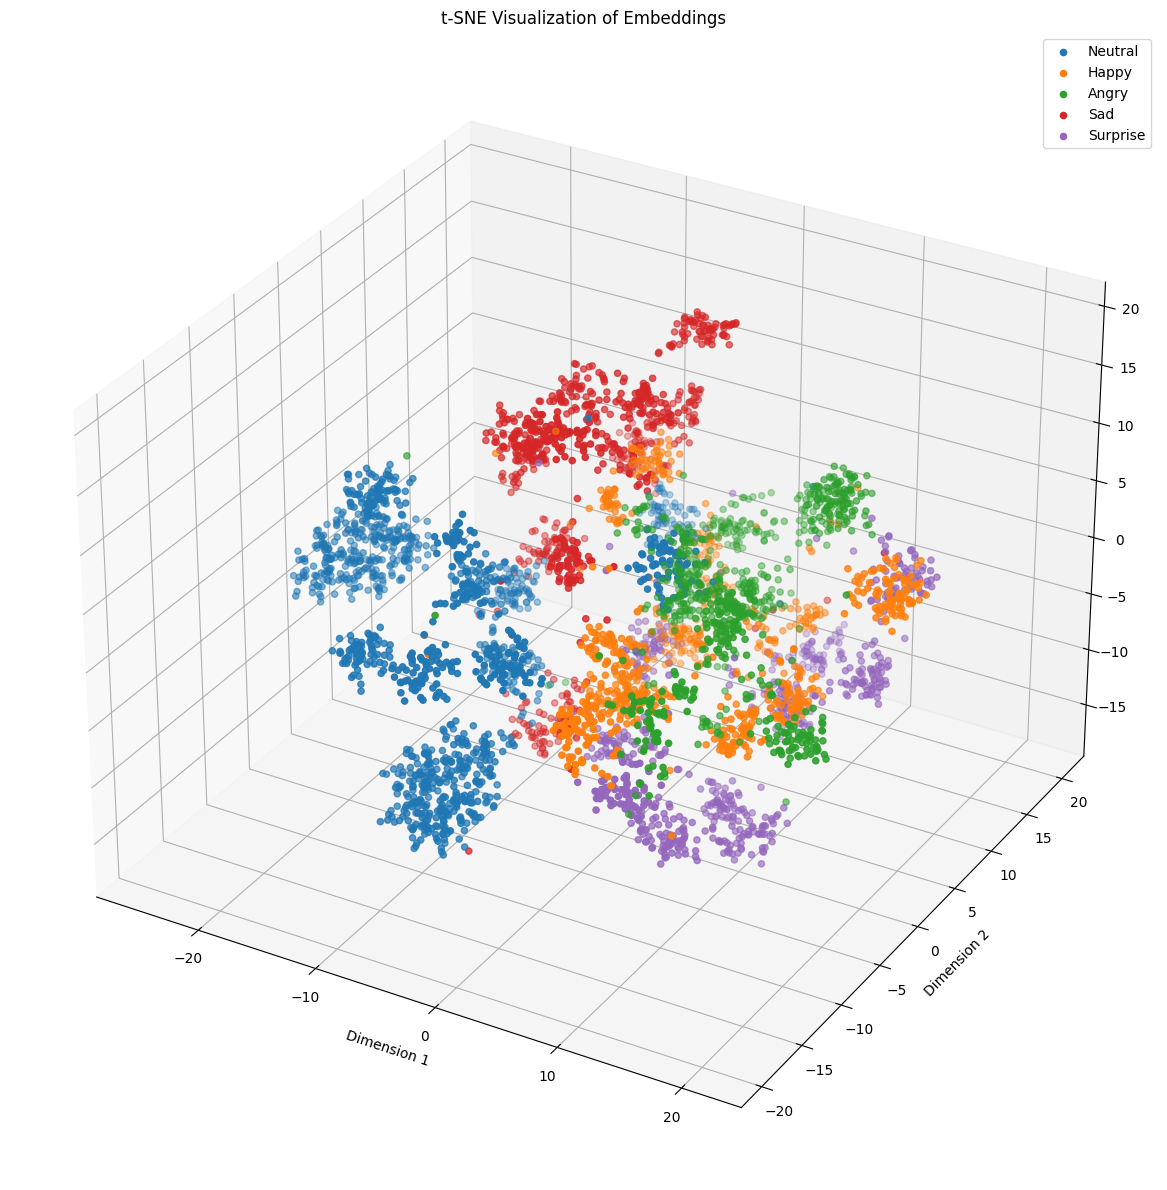

In [17]:
tsne = TSNE(n_components=3, random_state=42)
embeddings_2d = tsne.fit_transform(total_zhid)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for label in np.unique(total_ypred):
    cluster_points = embeddings_2d[total_ypred == label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=emotion_dict[label])

#plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker='o')
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
model.eval()
cm_test = create_confusion_matrix(model, test_dloader, n_class=5)

Accuracy: 0.9423736333847046


In [6]:
print('Accuracy: {:.4f}'.format(cm_test.trace()/cm_test.sum() ))
print('UAR(Unweighted Average Recall): {:.4f}\nWAR(Weighted Average Recall): {:.4f}'.format(average_recall(cm_test, weighted=False), average_recall(cm_test, weighted=True)))

Accuracy: 0.9424
UAR(Unweighted Average Recall): 0.9359
WAR(Weighted Average Recall): 0.9424


In [11]:
import seaborn as sn
def plot_cm(cm, normalize = False, ax = None):
    """
    plot Confusion Matrix
    
    """
    if not isinstance(cm,np.ndarray):
        cm = cm.detach().numpy()
    
    cm_df = pd.DataFrame(cm, columns = [ emotion_dict[i] for i in range(5) ], index=[ emotion_dict[i] for i in range(5) ] )
    factor = np.sum(cm_df, axis=1) if normalize else 1
    p = sn.heatmap(cm_df/factor, annot=True, ax=ax)
    p.set_ylabel('actual')
    p.set_xlabel('predicted')

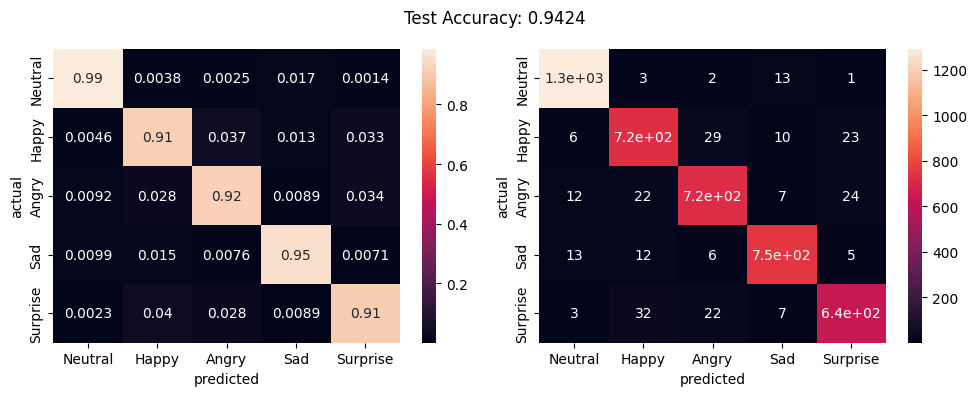

In [12]:
fig, axes = plt.subplots(1,2, figsize = (10, 4), dpi = 100)
plot_cm(cm_test, normalize=True, ax = axes[0])
plot_cm(cm_test, normalize=False, ax = axes[1])
fig.suptitle('Test Accuracy: {:.4f}'.format(cm_test.trace()/ cm_test.sum()))
plt.tight_layout()
plt.savefig(f'./{holdout_outdir}/img/cm.jpg')